In [160]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F

from utils2 import Logger

### Import dataset

In [113]:
batch_size_train = 100

data_dir = 'data/'

image_loader = torch.utils.data.DataLoader(
  datasets.MNIST(data_dir, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((.5), (.5))
                             ])),
  batch_size=batch_size_train, shuffle=True)

# Num batches
num_batches = len(image_loader)

### Convolution test

In [114]:
t1 = torch.ones(2,2,8, 8)

In [115]:

conv1 = nn.Conv2d(2, 3, kernel_size=4)

out = conv1(t1)
print(out.shape)

torch.Size([2, 3, 5, 5])


In [116]:
t1 = torch.ones(1,20,6, 6)
conv1 = nn.ConvTranspose2d(20, 10, kernel_size=5)
out = conv1(t1)
out.shape

torch.Size([1, 10, 10, 10])

In [117]:
tensor_test = torch.rand(100)

linear1 = nn.Linear(100, 200)
linear2 = nn.Linear(200, 540)

conv1 = nn.ConvTranspose2d(15, 10, kernel_size=10)
conv2 = nn.ConvTranspose2d(10, 1, kernel_size=14)

out = linear1(tensor_test)
out = linear2(out)
out = out.view(1, 15, 6, 6)
#out = torch.rand(1 , 20, 10, 10)
out = conv1(out)
out = conv2(out)
out.shape
#plt.imshow(out[0][0].detach().numpy(), cmap='gray', interpolation='none')

conv3 = nn.Conv2d(1, 10, kernel_size=5)
conv4 = nn.Conv2d(10, 20, kernel_size=5)
fc1 = nn.Linear(320, 50)
fc2 = nn.Linear(50, 10)

out = conv3(out)

### Defining networks

In [233]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),
        )
        self.hidden1 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(320, 50),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(50, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = x.view(-1, 320)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    

In [234]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        
        self.linear1 = nn.Sequential(
            nn.Linear(n_features, 200),
            nn.LeakyReLU(0.2)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(200, 540),
            nn.LeakyReLU(0.2)
        )
        self.conv1 = nn.Sequential(            
            nn.ConvTranspose2d(15, 10, kernel_size=10),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(10, 1, kernel_size=14),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = x.view(-1, 15, 6, 6)
        x = self.conv1(x)
        x = self.conv2(x)
        return x
    

In [235]:
tensor_test = torch.rand(100)

linear1 = nn.Linear(100, 200)
linear2 = nn.Linear(200, 540)

conv1 = nn.ConvTranspose2d(15, 10, kernel_size=10)
conv2 = nn.ConvTranspose2d(10, 1, kernel_size=14)

out = linear1(tensor_test)
out = linear2(out)
out = out.view(-1, 15, 6, 6)
#out = torch.rand(1 , 20, 10, 10)
out = conv1(out)
out = conv2(out)
out.shape

torch.Size([1, 1, 28, 28])

### Helper functions

In [236]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

### Training

In [237]:
#check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [238]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

generator.to(device)
discriminator.to(device)

#Define loss function and both optimizer functions
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

In [239]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N).to(device) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N).to(device))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [240]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    #Send data to device
    fake_data = fake_data.to(device)
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N).to(device))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [241]:
num_test_samples = 16
test_noise = noise(num_test_samples).to(device)

In [253]:
#Test here
#fake_data = generator(noise(3).to(device)).detach()
#plt.imshow(fake_data[0][0].cpu().detach().numpy(), cmap='gray', interpolation='none')
test = noise(3)
test.shape

torch.Size([3, 100])

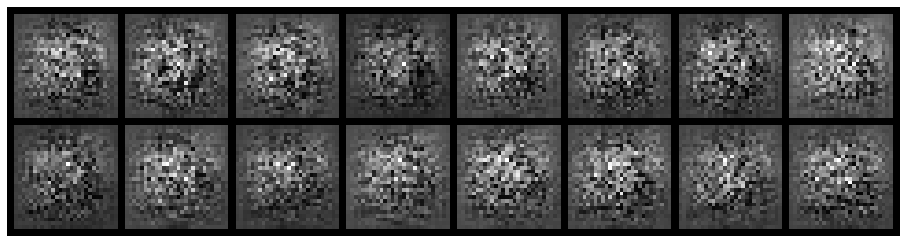

Epoch: [0/50], Batch Num: [0/600]
Discriminator Loss: 1.4100, Generator Loss: 0.7022
D(x): 0.4835, D(G(z)): 0.4949


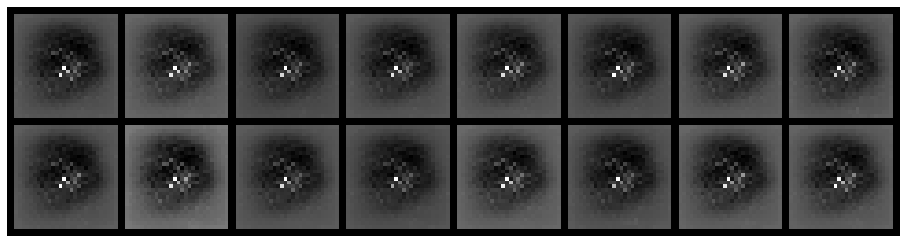

Epoch: [0/50], Batch Num: [100/600]
Discriminator Loss: 0.9228, Generator Loss: 0.8627
D(x): 0.6890, D(G(z)): 0.4213


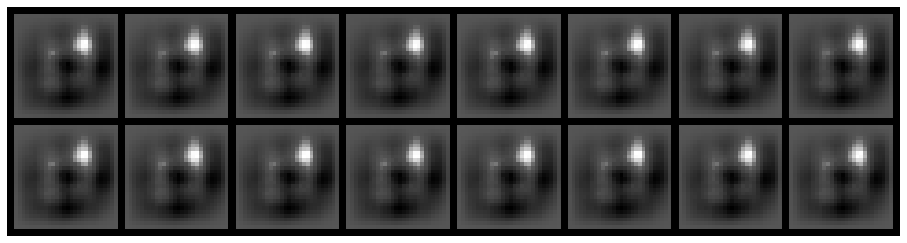

Epoch: [0/50], Batch Num: [200/600]
Discriminator Loss: 1.1625, Generator Loss: 1.4505
D(x): 0.5727, D(G(z)): 0.3636


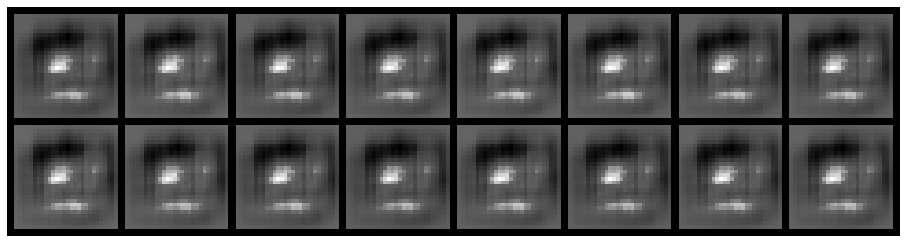

Epoch: [0/50], Batch Num: [300/600]
Discriminator Loss: 1.1800, Generator Loss: 1.0985
D(x): 0.5598, D(G(z)): 0.4105


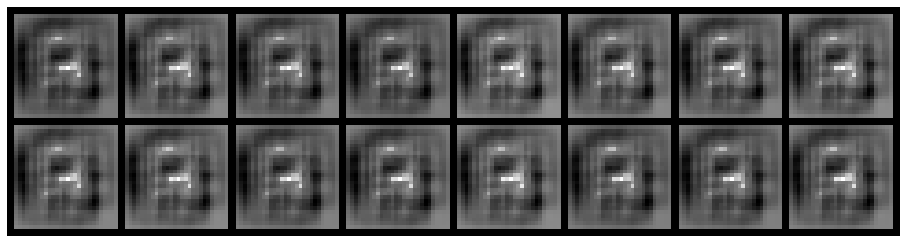

Epoch: [0/50], Batch Num: [400/600]
Discriminator Loss: 1.2487, Generator Loss: 1.1181
D(x): 0.4981, D(G(z)): 0.3890


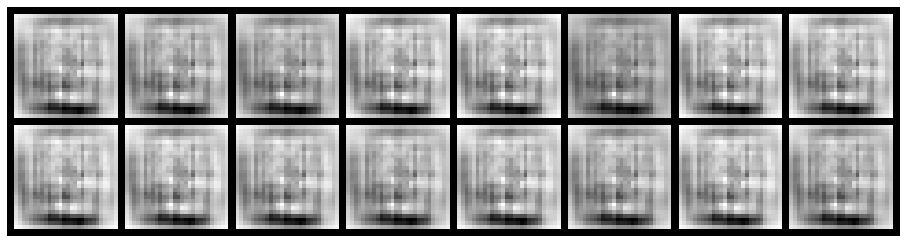

Epoch: [0/50], Batch Num: [500/600]
Discriminator Loss: 0.8575, Generator Loss: 1.3063
D(x): 0.6533, D(G(z)): 0.3068


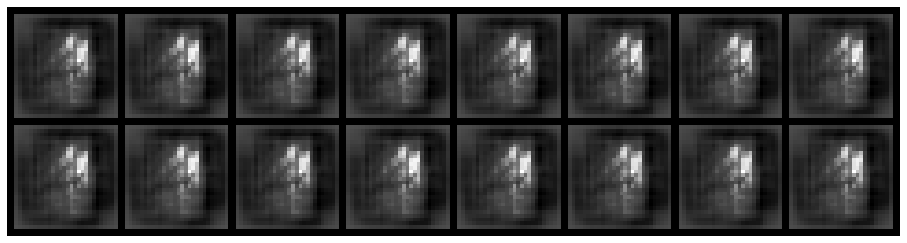

Epoch: [1/50], Batch Num: [0/600]
Discriminator Loss: 1.6551, Generator Loss: 0.9955
D(x): 0.3641, D(G(z)): 0.4174


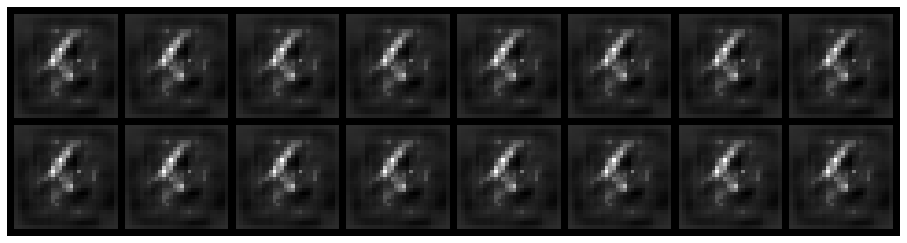

Epoch: [1/50], Batch Num: [100/600]
Discriminator Loss: 1.4436, Generator Loss: 0.9216
D(x): 0.4413, D(G(z)): 0.4482


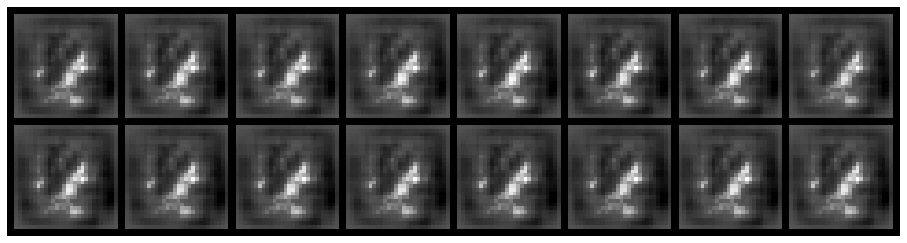

Epoch: [1/50], Batch Num: [200/600]
Discriminator Loss: 1.0995, Generator Loss: 1.1007
D(x): 0.5404, D(G(z)): 0.3549


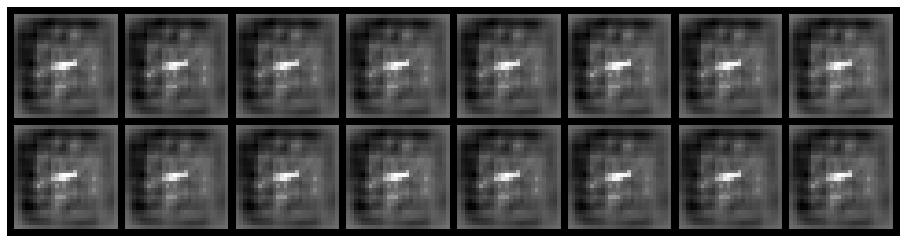

Epoch: [1/50], Batch Num: [300/600]
Discriminator Loss: 1.2118, Generator Loss: 0.8736
D(x): 0.5804, D(G(z)): 0.4523


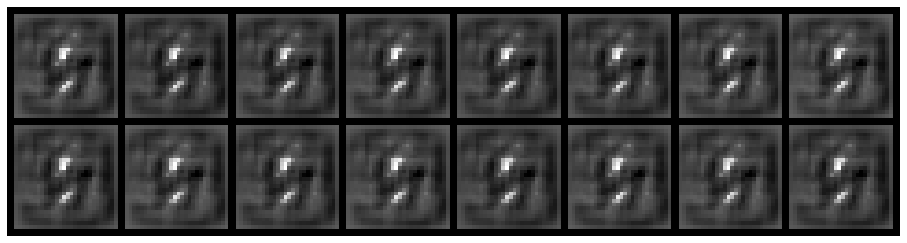

Epoch: [1/50], Batch Num: [400/600]
Discriminator Loss: 1.3459, Generator Loss: 0.7137
D(x): 0.5689, D(G(z)): 0.5173


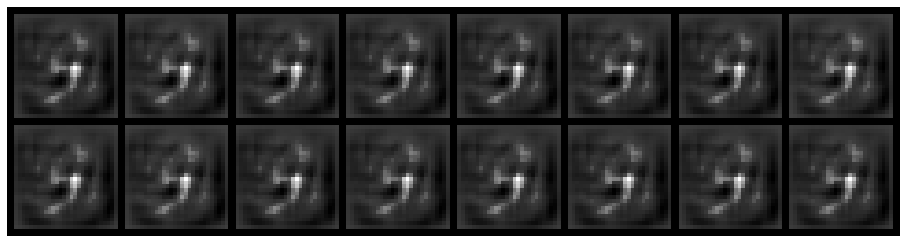

Epoch: [1/50], Batch Num: [500/600]
Discriminator Loss: 0.9972, Generator Loss: 1.0959
D(x): 0.6047, D(G(z)): 0.3659


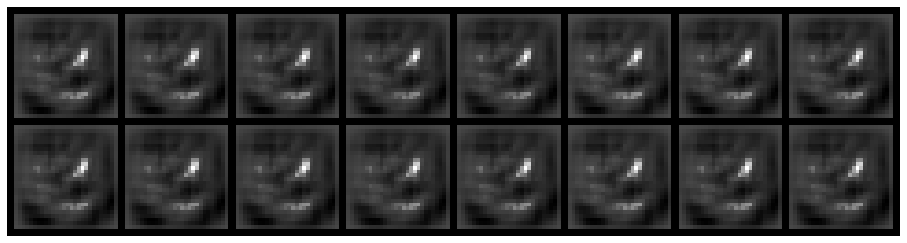

Epoch: [2/50], Batch Num: [0/600]
Discriminator Loss: 1.3730, Generator Loss: 0.9421
D(x): 0.4866, D(G(z)): 0.4337


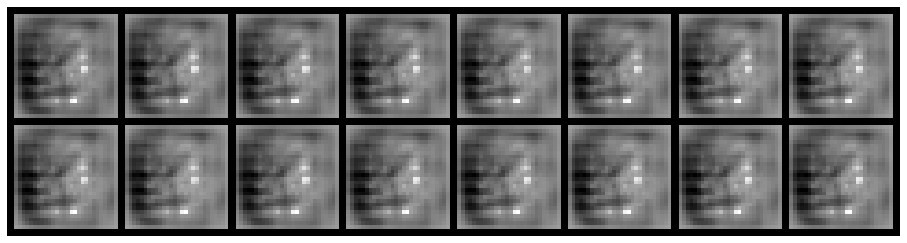

Epoch: [2/50], Batch Num: [100/600]
Discriminator Loss: 1.3133, Generator Loss: 1.2316
D(x): 0.5116, D(G(z)): 0.3800


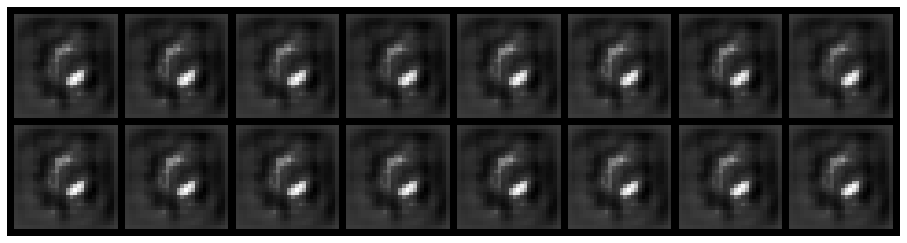

Epoch: [2/50], Batch Num: [200/600]
Discriminator Loss: 1.2371, Generator Loss: 1.1794
D(x): 0.5031, D(G(z)): 0.2972


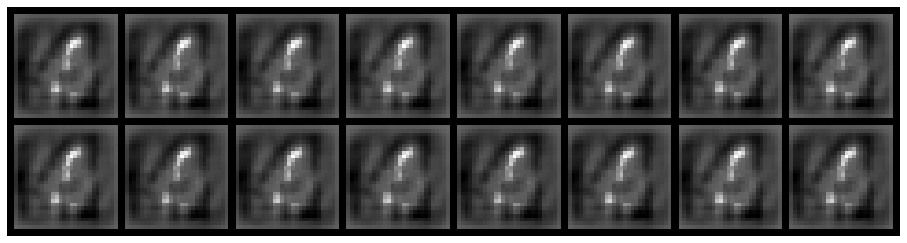

Epoch: [2/50], Batch Num: [300/600]
Discriminator Loss: 1.0950, Generator Loss: 1.0899
D(x): 0.5969, D(G(z)): 0.3827


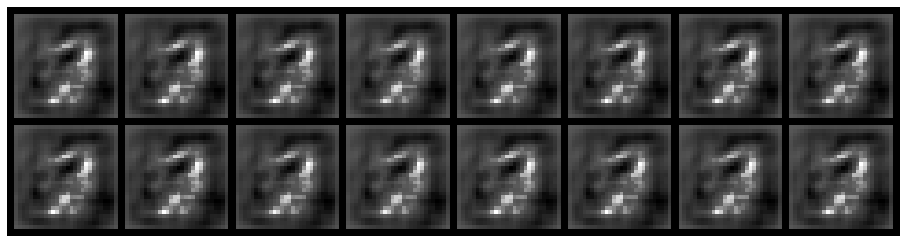

Epoch: [2/50], Batch Num: [400/600]
Discriminator Loss: 1.3818, Generator Loss: 0.8925
D(x): 0.5759, D(G(z)): 0.4959


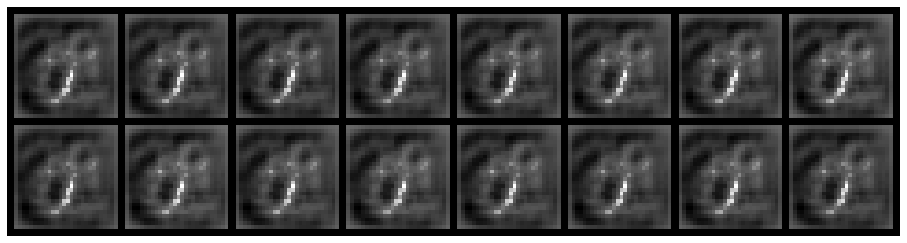

Epoch: [2/50], Batch Num: [500/600]
Discriminator Loss: 1.3100, Generator Loss: 1.0809
D(x): 0.5511, D(G(z)): 0.4032


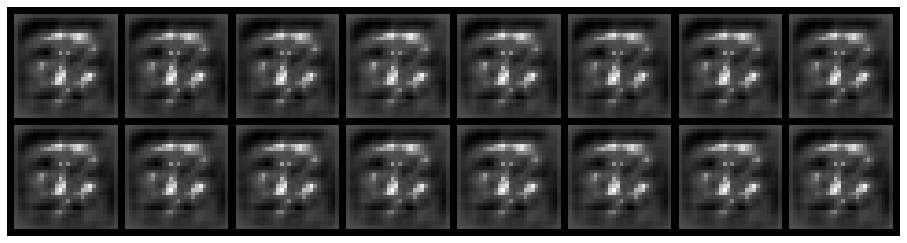

Epoch: [3/50], Batch Num: [0/600]
Discriminator Loss: 0.9629, Generator Loss: 1.1865
D(x): 0.6816, D(G(z)): 0.3780


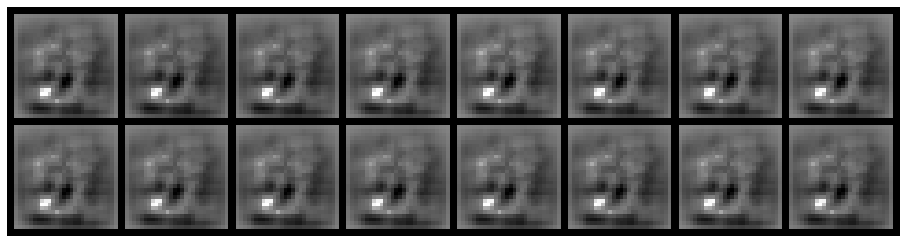

Epoch: [3/50], Batch Num: [100/600]
Discriminator Loss: 0.9570, Generator Loss: 1.6401
D(x): 0.5883, D(G(z)): 0.2580


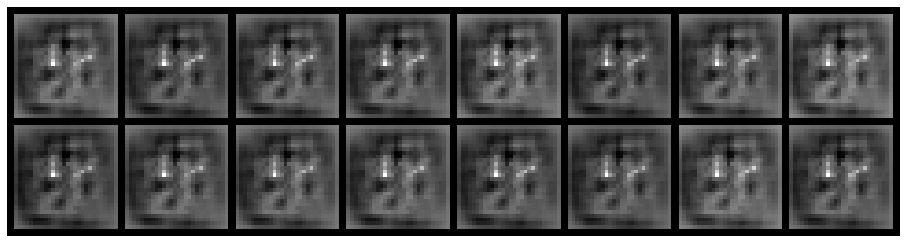

Epoch: [3/50], Batch Num: [200/600]
Discriminator Loss: 0.6785, Generator Loss: 1.4175
D(x): 0.7679, D(G(z)): 0.2794


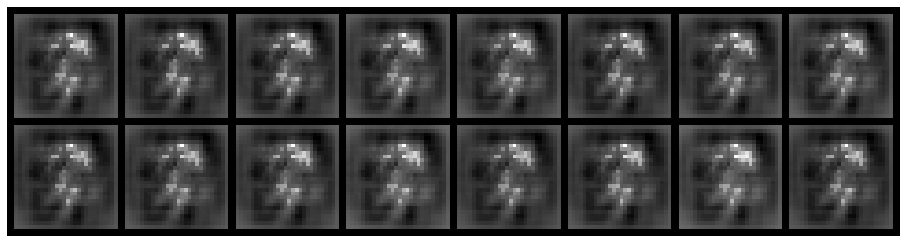

Epoch: [3/50], Batch Num: [300/600]
Discriminator Loss: 1.1184, Generator Loss: 1.3972
D(x): 0.7492, D(G(z)): 0.4261


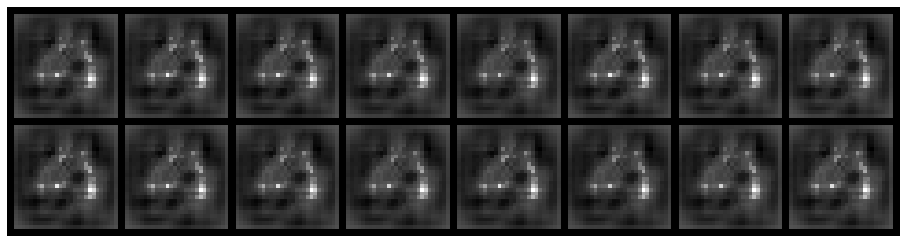

Epoch: [3/50], Batch Num: [400/600]
Discriminator Loss: 0.8691, Generator Loss: 1.7603
D(x): 0.6725, D(G(z)): 0.2577


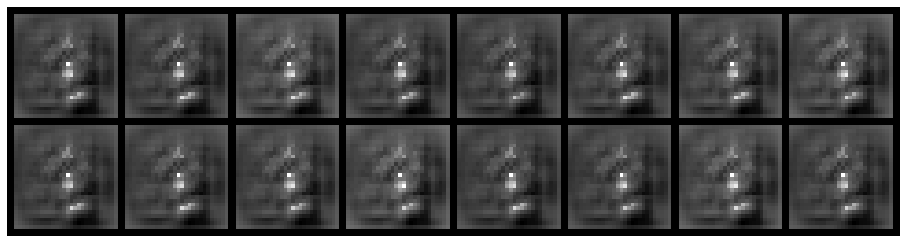

Epoch: [3/50], Batch Num: [500/600]
Discriminator Loss: 0.5786, Generator Loss: 1.6296
D(x): 0.7941, D(G(z)): 0.2417


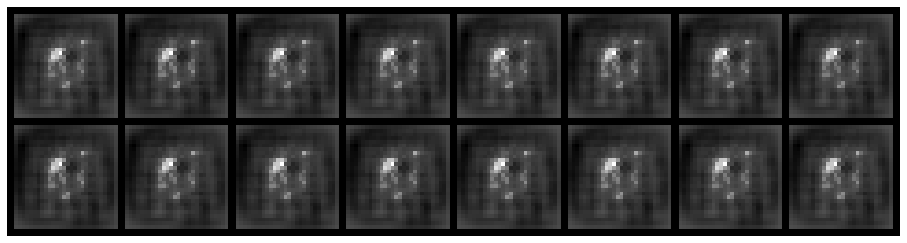

Epoch: [4/50], Batch Num: [0/600]
Discriminator Loss: 0.9144, Generator Loss: 1.6193
D(x): 0.6899, D(G(z)): 0.2979


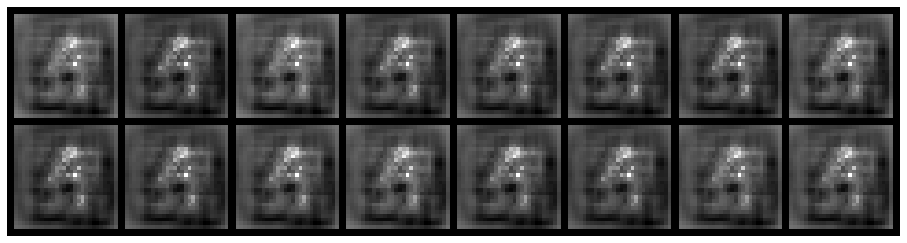

Epoch: [4/50], Batch Num: [100/600]
Discriminator Loss: 0.4918, Generator Loss: 1.6305
D(x): 0.8128, D(G(z)): 0.2029


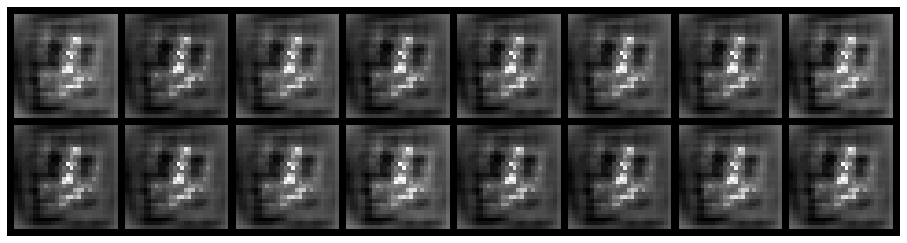

Epoch: [4/50], Batch Num: [200/600]
Discriminator Loss: 0.8603, Generator Loss: 2.0332
D(x): 0.7339, D(G(z)): 0.2705


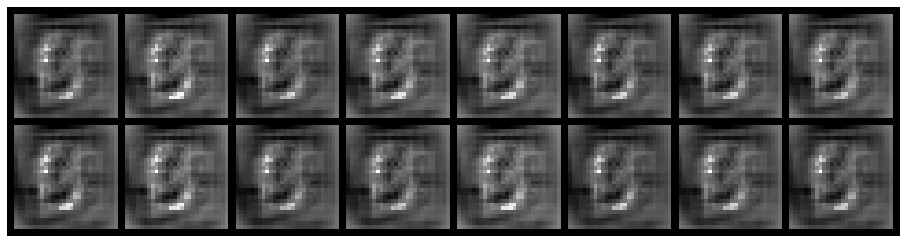

Epoch: [4/50], Batch Num: [300/600]
Discriminator Loss: 0.4142, Generator Loss: 1.8872
D(x): 0.9050, D(G(z)): 0.1941


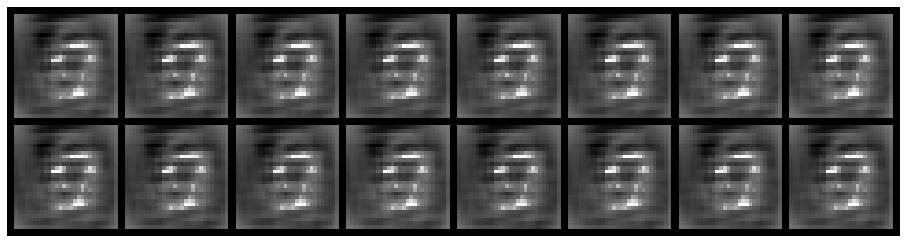

Epoch: [4/50], Batch Num: [400/600]
Discriminator Loss: 0.3725, Generator Loss: 2.7602
D(x): 0.8506, D(G(z)): 0.1215


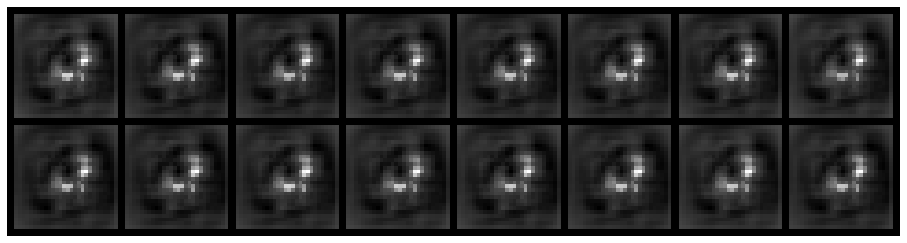

Epoch: [4/50], Batch Num: [500/600]
Discriminator Loss: 0.4345, Generator Loss: 2.8948
D(x): 0.8643, D(G(z)): 0.1449


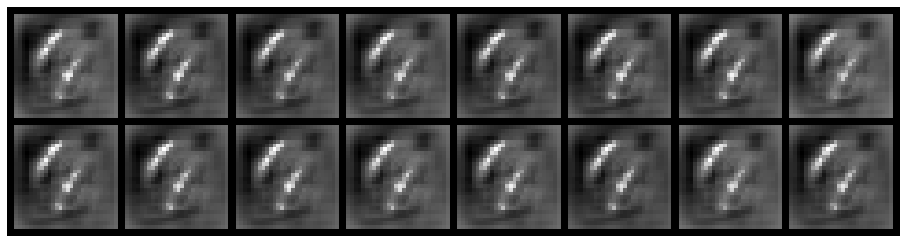

Epoch: [5/50], Batch Num: [0/600]
Discriminator Loss: 0.3281, Generator Loss: 2.0534
D(x): 0.9042, D(G(z)): 0.1725


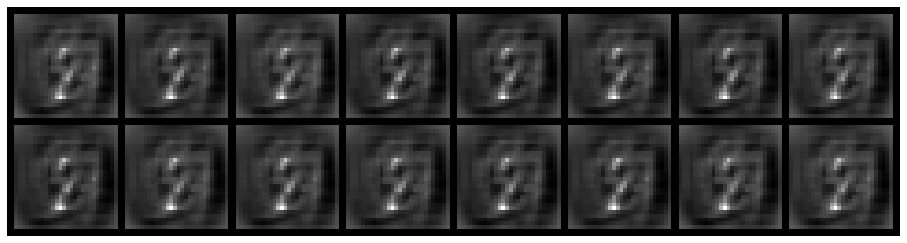

Epoch: [5/50], Batch Num: [100/600]
Discriminator Loss: 0.4899, Generator Loss: 2.5871
D(x): 0.8434, D(G(z)): 0.1478


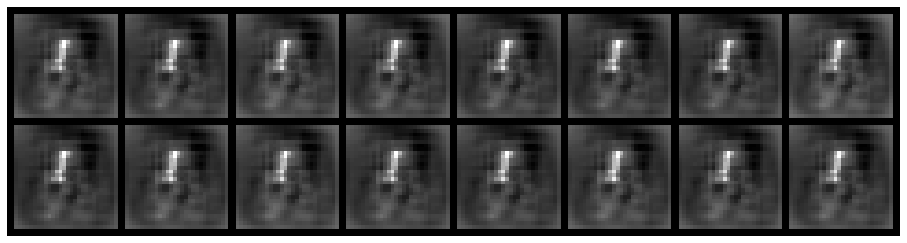

Epoch: [5/50], Batch Num: [200/600]
Discriminator Loss: 0.2302, Generator Loss: 3.5316
D(x): 0.9082, D(G(z)): 0.0937


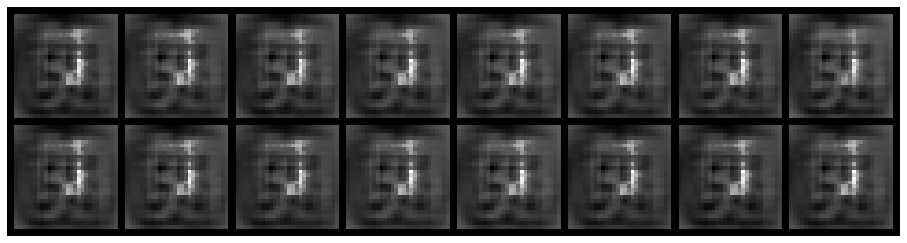

Epoch: [5/50], Batch Num: [300/600]
Discriminator Loss: 0.4351, Generator Loss: 2.4054
D(x): 0.8711, D(G(z)): 0.1629


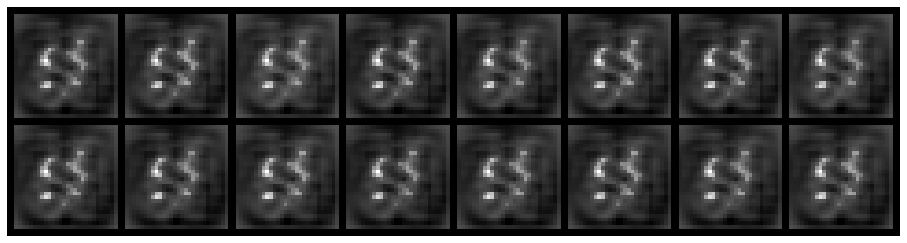

Epoch: [5/50], Batch Num: [400/600]
Discriminator Loss: 0.6355, Generator Loss: 2.5623
D(x): 0.7965, D(G(z)): 0.1729


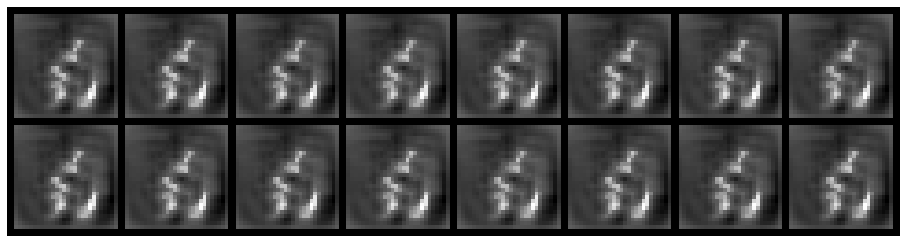

Epoch: [5/50], Batch Num: [500/600]
Discriminator Loss: 0.6352, Generator Loss: 3.4130
D(x): 0.7853, D(G(z)): 0.0972


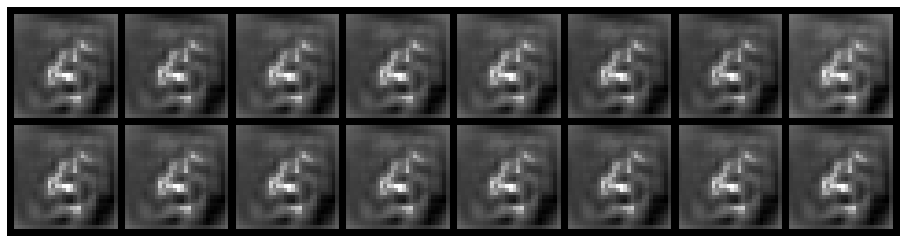

Epoch: [6/50], Batch Num: [0/600]
Discriminator Loss: 0.3193, Generator Loss: 3.1991
D(x): 0.8834, D(G(z)): 0.1145


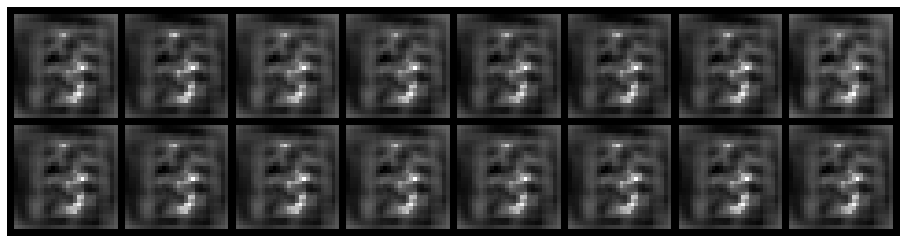

Epoch: [6/50], Batch Num: [100/600]
Discriminator Loss: 0.3211, Generator Loss: 2.2755
D(x): 0.9115, D(G(z)): 0.1384


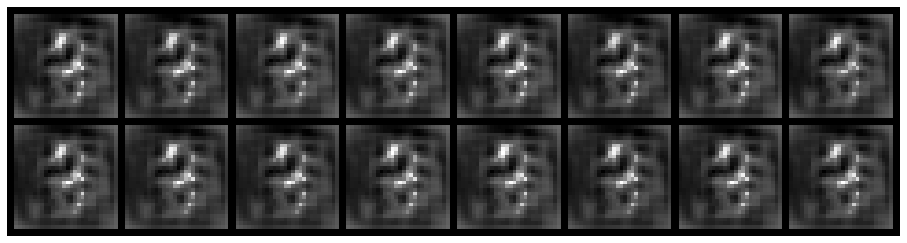

Epoch: [6/50], Batch Num: [200/600]
Discriminator Loss: 0.3265, Generator Loss: 3.2070
D(x): 0.9039, D(G(z)): 0.0996


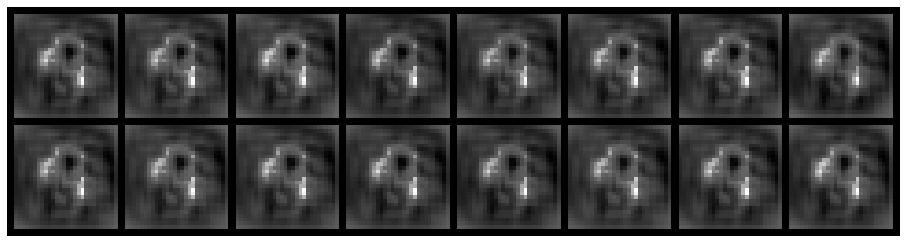

Epoch: [6/50], Batch Num: [300/600]
Discriminator Loss: 0.1432, Generator Loss: 2.6109
D(x): 0.9732, D(G(z)): 0.0987


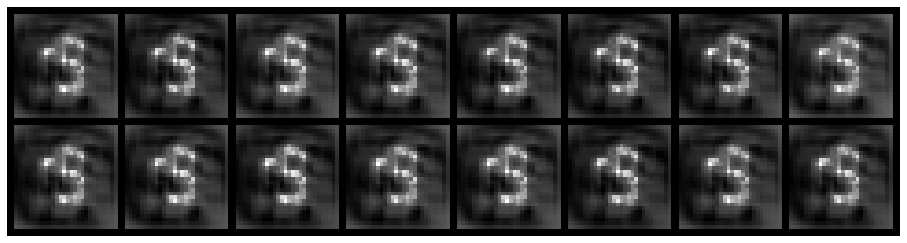

Epoch: [6/50], Batch Num: [400/600]
Discriminator Loss: 0.2995, Generator Loss: 3.1618
D(x): 0.9199, D(G(z)): 0.1043


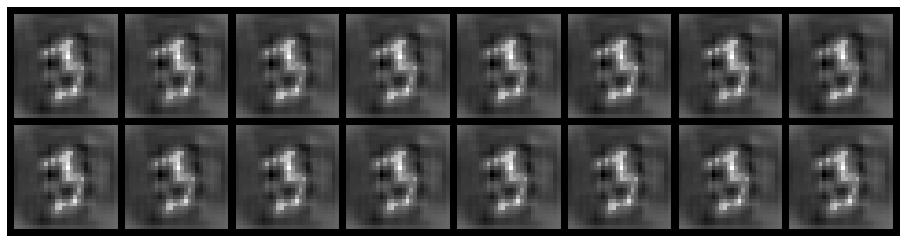

Epoch: [6/50], Batch Num: [500/600]
Discriminator Loss: 0.3584, Generator Loss: 4.8429
D(x): 0.8645, D(G(z)): 0.0451


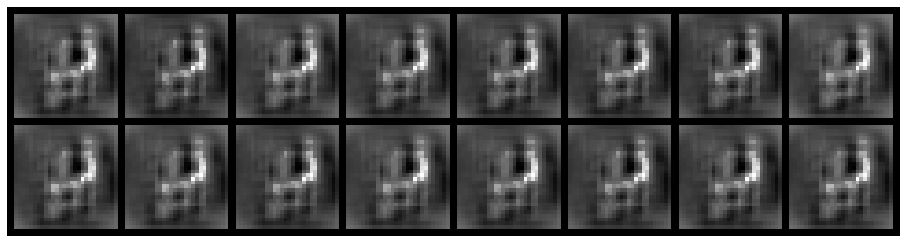

Epoch: [7/50], Batch Num: [0/600]
Discriminator Loss: 0.2743, Generator Loss: 3.0142
D(x): 0.9170, D(G(z)): 0.1095


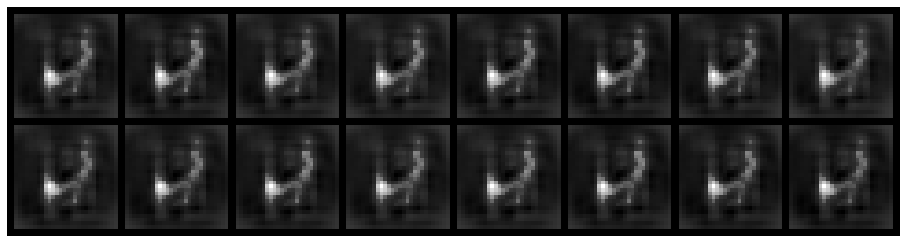

Epoch: [7/50], Batch Num: [100/600]
Discriminator Loss: 0.1781, Generator Loss: 4.8823
D(x): 0.9497, D(G(z)): 0.0730


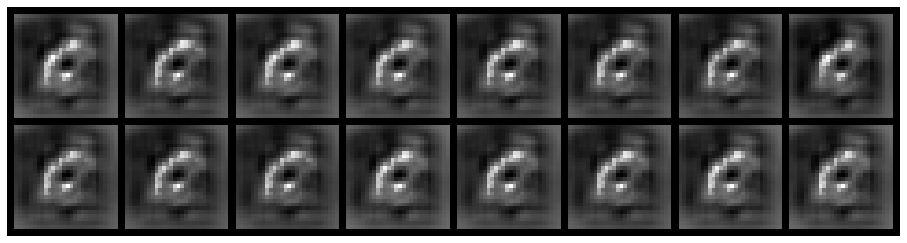

Epoch: [7/50], Batch Num: [200/600]
Discriminator Loss: 0.2250, Generator Loss: 4.2455
D(x): 0.9193, D(G(z)): 0.0466


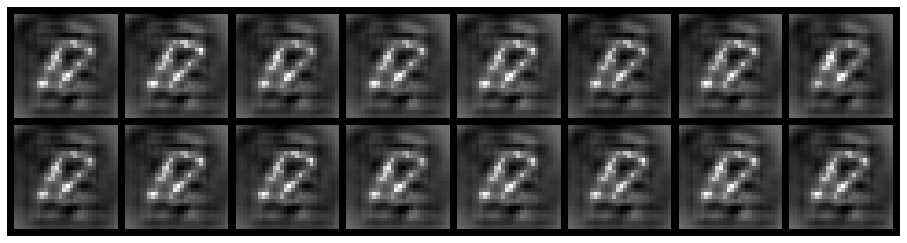

Epoch: [7/50], Batch Num: [300/600]
Discriminator Loss: 0.1459, Generator Loss: 4.3880
D(x): 0.9461, D(G(z)): 0.0417


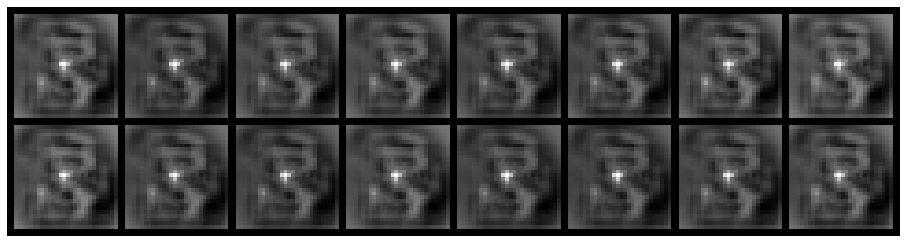

Epoch: [7/50], Batch Num: [400/600]
Discriminator Loss: 0.0867, Generator Loss: 3.8104
D(x): 0.9720, D(G(z)): 0.0408


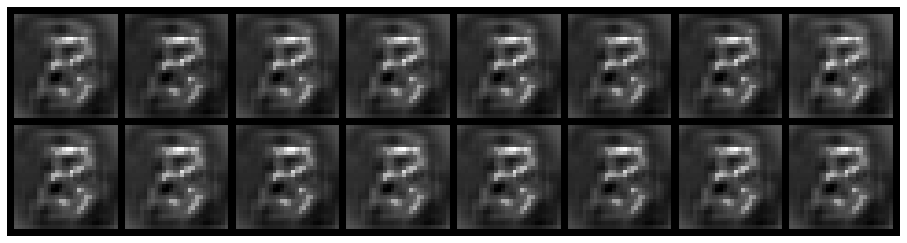

Epoch: [7/50], Batch Num: [500/600]
Discriminator Loss: 0.1748, Generator Loss: 3.8308
D(x): 0.9303, D(G(z)): 0.0313


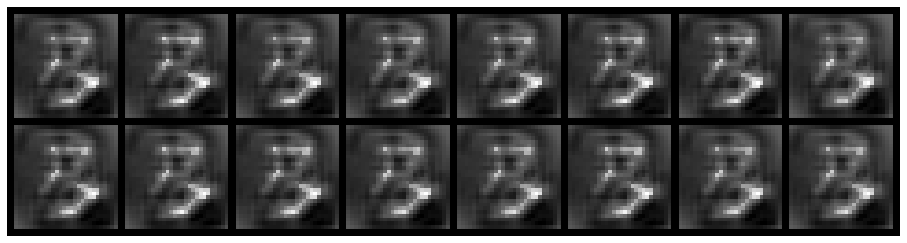

Epoch: [8/50], Batch Num: [0/600]
Discriminator Loss: 0.1692, Generator Loss: 3.8733
D(x): 0.9559, D(G(z)): 0.0552


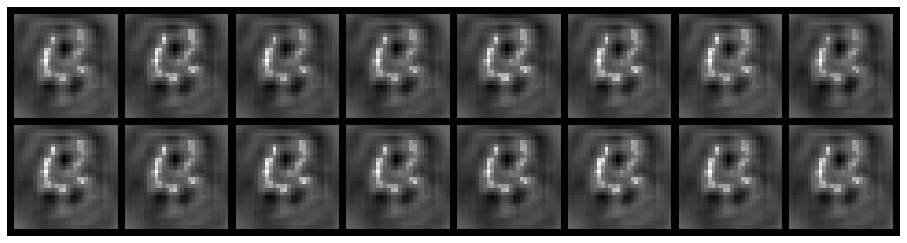

Epoch: [8/50], Batch Num: [100/600]
Discriminator Loss: 0.1653, Generator Loss: 3.7066
D(x): 0.9671, D(G(z)): 0.0676


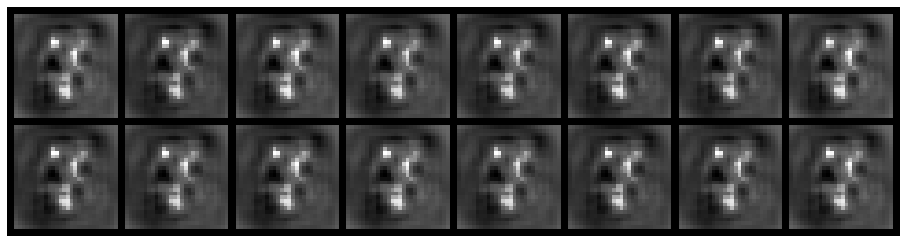

Epoch: [8/50], Batch Num: [200/600]
Discriminator Loss: 0.3365, Generator Loss: 4.9165
D(x): 0.8871, D(G(z)): 0.0755


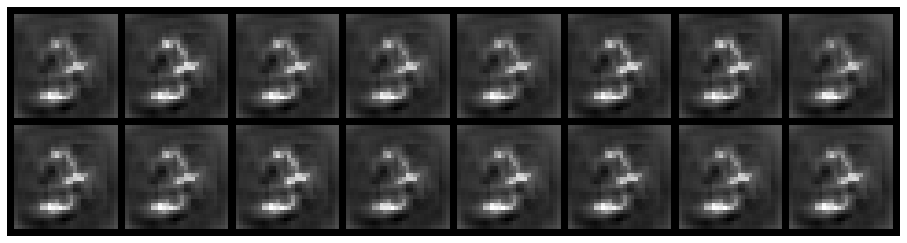

Epoch: [8/50], Batch Num: [300/600]
Discriminator Loss: 0.3190, Generator Loss: 3.4658
D(x): 0.9047, D(G(z)): 0.0780


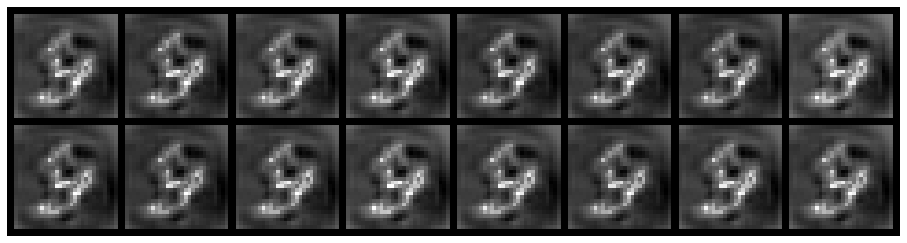

Epoch: [8/50], Batch Num: [400/600]
Discriminator Loss: 0.2536, Generator Loss: 3.3029
D(x): 0.9115, D(G(z)): 0.0945


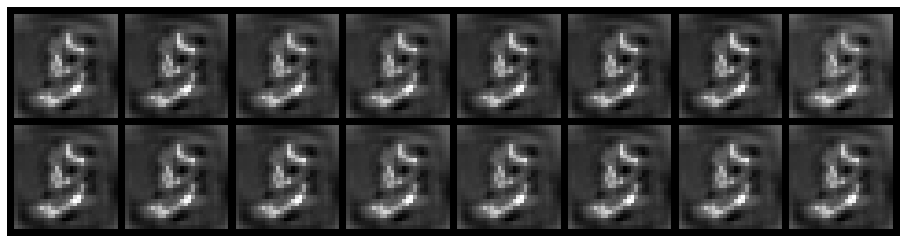

Epoch: [8/50], Batch Num: [500/600]
Discriminator Loss: 0.1974, Generator Loss: 4.2691
D(x): 0.9407, D(G(z)): 0.0910


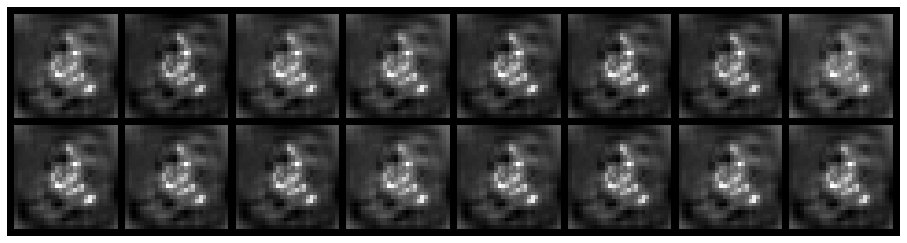

Epoch: [9/50], Batch Num: [0/600]
Discriminator Loss: 0.1375, Generator Loss: 3.5308
D(x): 0.9506, D(G(z)): 0.0589


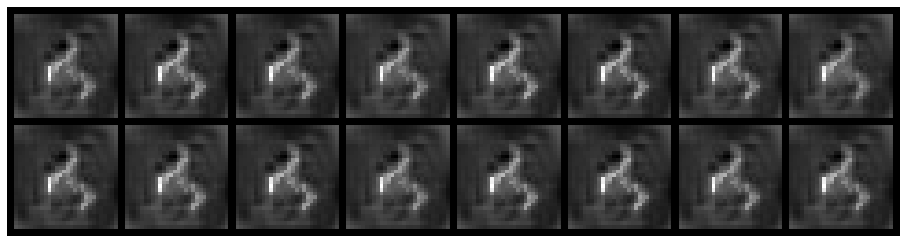

Epoch: [9/50], Batch Num: [100/600]
Discriminator Loss: 0.1319, Generator Loss: 4.6715
D(x): 0.9418, D(G(z)): 0.0311


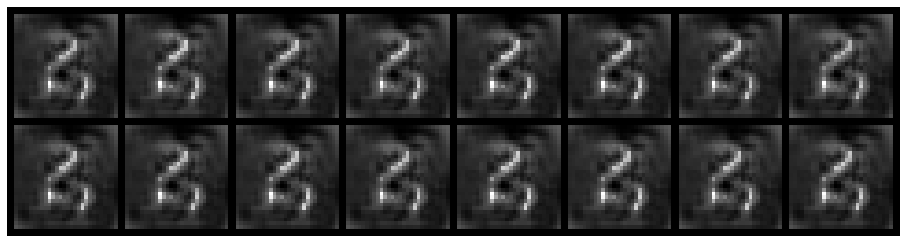

Epoch: [9/50], Batch Num: [200/600]
Discriminator Loss: 0.1115, Generator Loss: 3.8745
D(x): 0.9755, D(G(z)): 0.0463


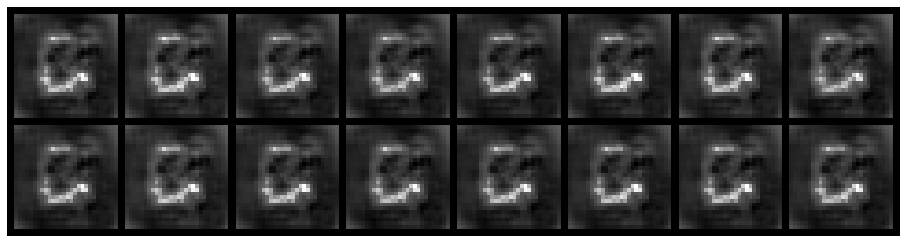

Epoch: [9/50], Batch Num: [300/600]
Discriminator Loss: 0.0992, Generator Loss: 3.3381
D(x): 0.9788, D(G(z)): 0.0497


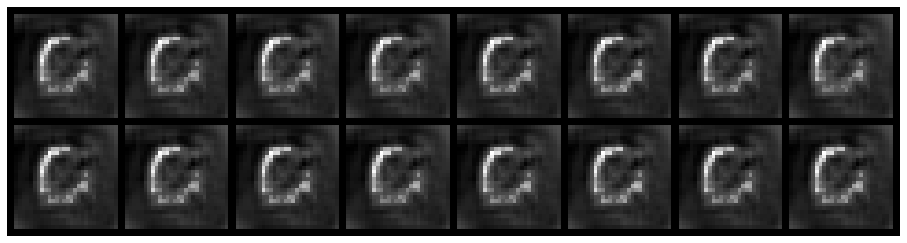

Epoch: [9/50], Batch Num: [400/600]
Discriminator Loss: 0.1093, Generator Loss: 5.3612
D(x): 0.9628, D(G(z)): 0.0167


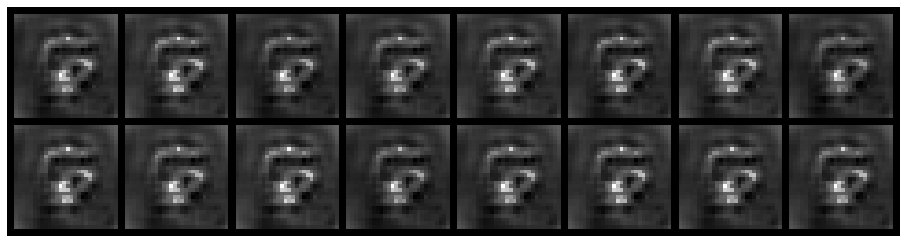

Epoch: [9/50], Batch Num: [500/600]
Discriminator Loss: 0.2090, Generator Loss: 4.0022
D(x): 0.9204, D(G(z)): 0.0364


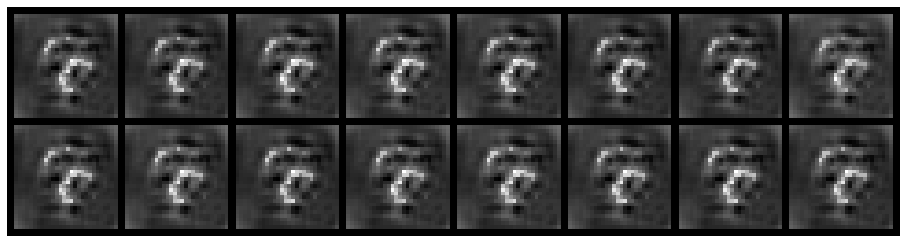

Epoch: [10/50], Batch Num: [0/600]
Discriminator Loss: 0.1065, Generator Loss: 4.8037
D(x): 0.9572, D(G(z)): 0.0226


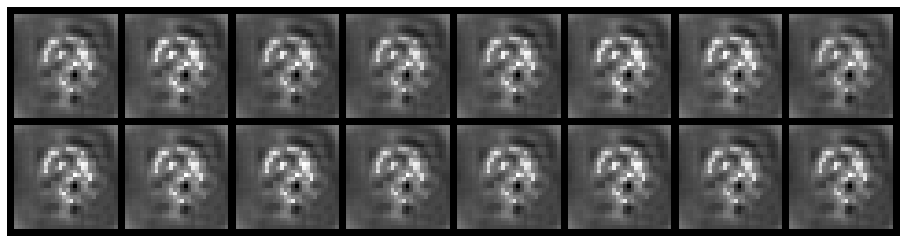

Epoch: [10/50], Batch Num: [100/600]
Discriminator Loss: 0.0896, Generator Loss: 3.5572
D(x): 0.9817, D(G(z)): 0.0546


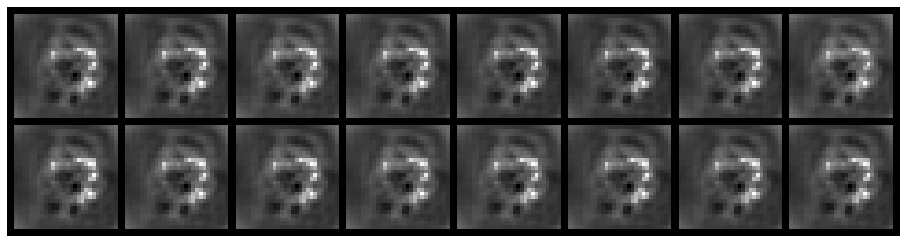

Epoch: [10/50], Batch Num: [200/600]
Discriminator Loss: 0.0390, Generator Loss: 4.5010
D(x): 0.9884, D(G(z)): 0.0245


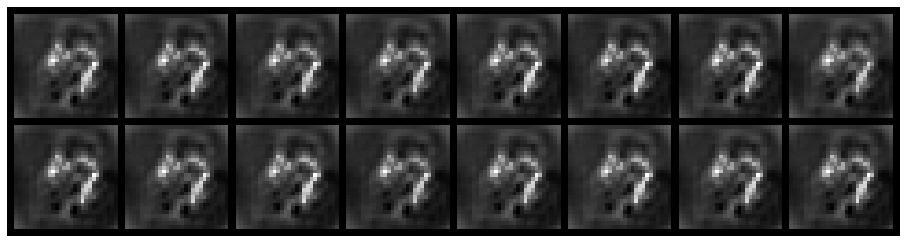

Epoch: [10/50], Batch Num: [300/600]
Discriminator Loss: 0.1074, Generator Loss: 5.1560
D(x): 0.9634, D(G(z)): 0.0152


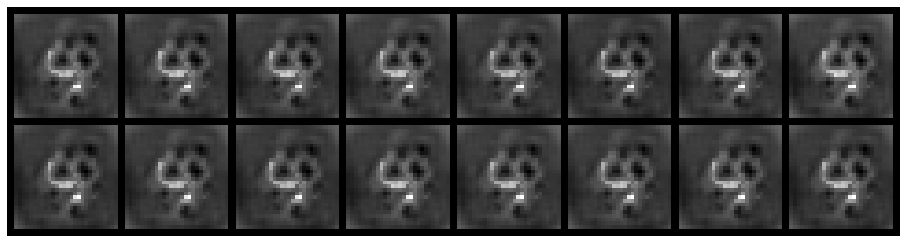

Epoch: [10/50], Batch Num: [400/600]
Discriminator Loss: 0.1389, Generator Loss: 4.2785
D(x): 0.9616, D(G(z)): 0.0497


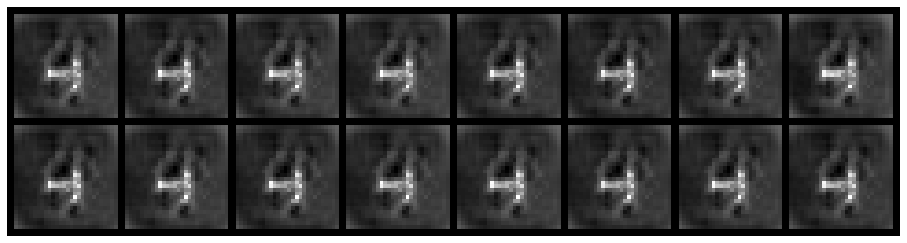

Epoch: [10/50], Batch Num: [500/600]
Discriminator Loss: 0.1649, Generator Loss: 4.5389
D(x): 0.9652, D(G(z)): 0.0402


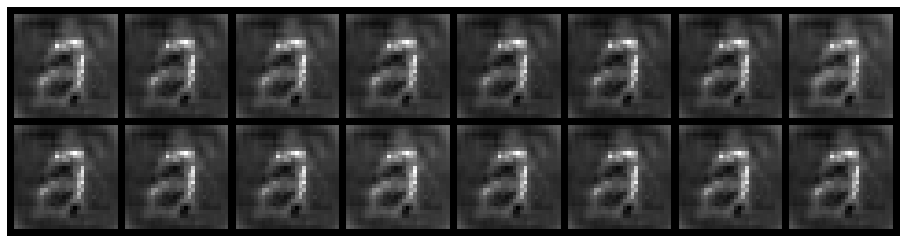

Epoch: [11/50], Batch Num: [0/600]
Discriminator Loss: 0.1470, Generator Loss: 4.4290
D(x): 0.9561, D(G(z)): 0.0413


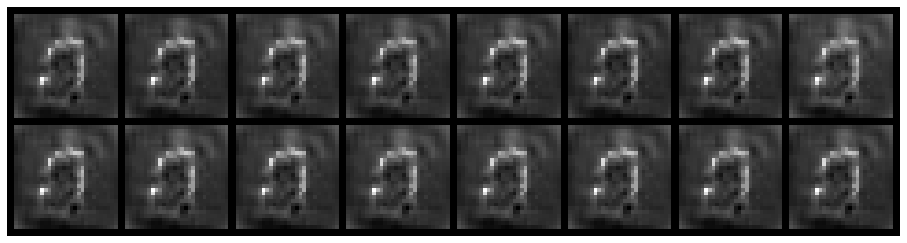

Epoch: [11/50], Batch Num: [100/600]
Discriminator Loss: 0.0812, Generator Loss: 4.5900
D(x): 0.9815, D(G(z)): 0.0410


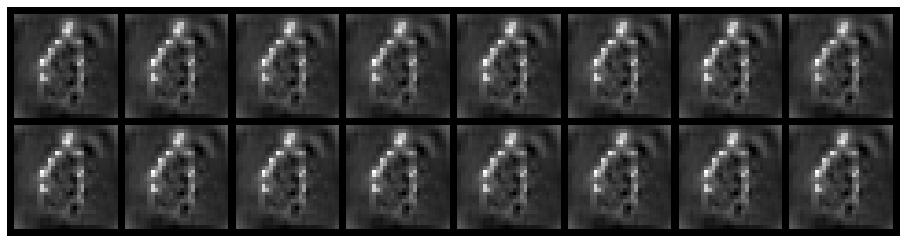

Epoch: [11/50], Batch Num: [200/600]
Discriminator Loss: 0.0849, Generator Loss: 5.8484
D(x): 0.9848, D(G(z)): 0.0131


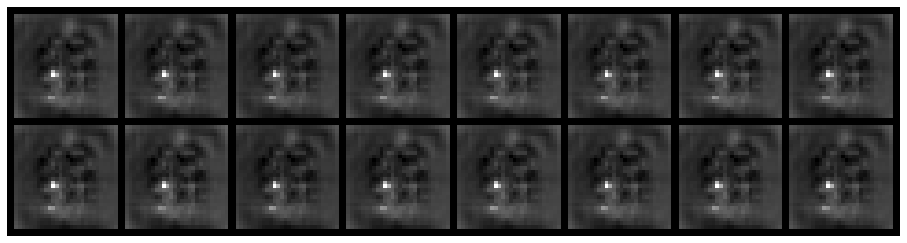

Epoch: [11/50], Batch Num: [300/600]
Discriminator Loss: 0.0737, Generator Loss: 5.6900
D(x): 0.9774, D(G(z)): 0.0369


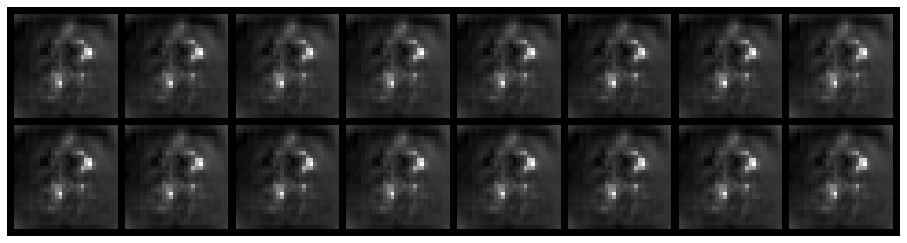

Epoch: [11/50], Batch Num: [400/600]
Discriminator Loss: 0.1845, Generator Loss: 4.9693
D(x): 0.9409, D(G(z)): 0.0140


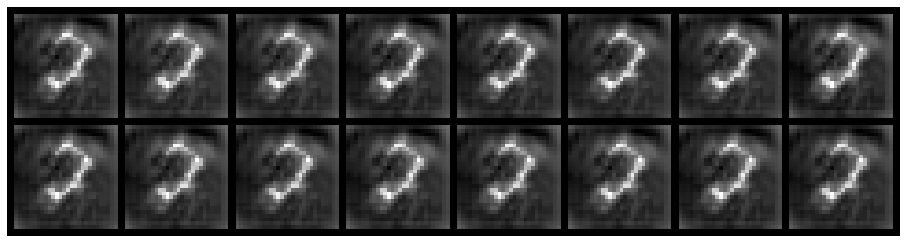

Epoch: [11/50], Batch Num: [500/600]
Discriminator Loss: 0.1122, Generator Loss: 4.7643
D(x): 0.9731, D(G(z)): 0.0251


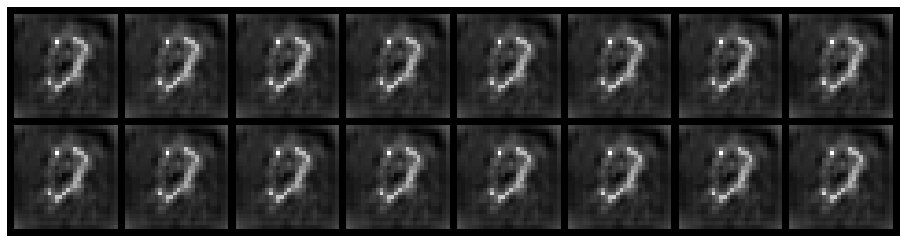

Epoch: [12/50], Batch Num: [0/600]
Discriminator Loss: 0.0358, Generator Loss: 5.7243
D(x): 0.9921, D(G(z)): 0.0216


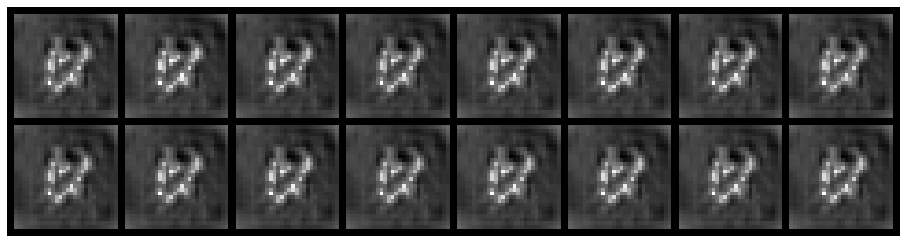

Epoch: [12/50], Batch Num: [100/600]
Discriminator Loss: 0.0941, Generator Loss: 4.9336
D(x): 0.9637, D(G(z)): 0.0204


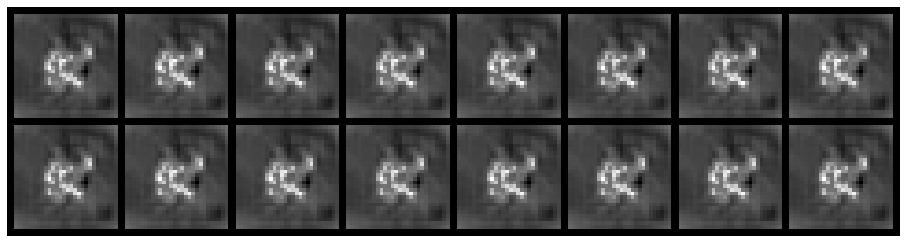

Epoch: [12/50], Batch Num: [200/600]
Discriminator Loss: 0.0117, Generator Loss: 5.9450
D(x): 0.9962, D(G(z)): 0.0075


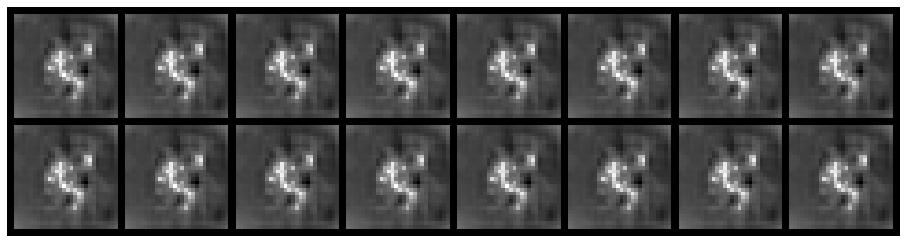

Epoch: [12/50], Batch Num: [300/600]
Discriminator Loss: 0.1713, Generator Loss: 5.5986
D(x): 0.9515, D(G(z)): 0.0218


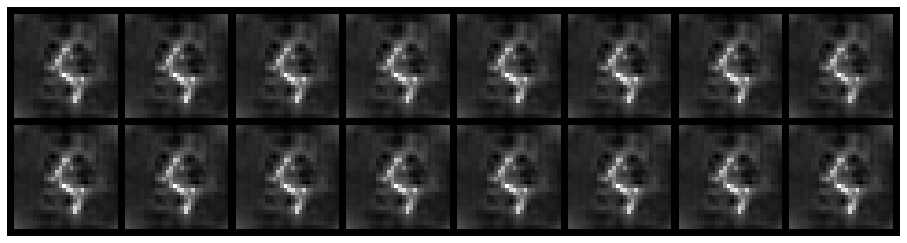

Epoch: [12/50], Batch Num: [400/600]
Discriminator Loss: 0.0270, Generator Loss: 4.9139
D(x): 0.9916, D(G(z)): 0.0165


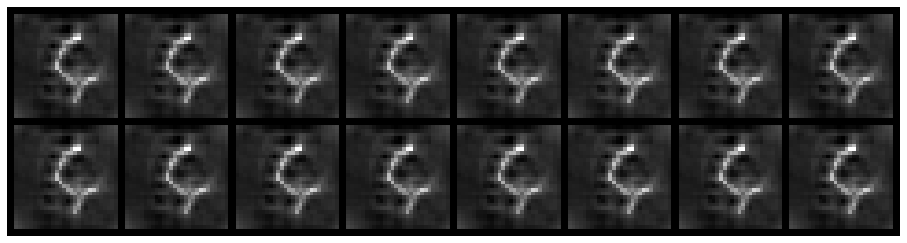

Epoch: [12/50], Batch Num: [500/600]
Discriminator Loss: 0.0645, Generator Loss: 4.9421
D(x): 0.9828, D(G(z)): 0.0253


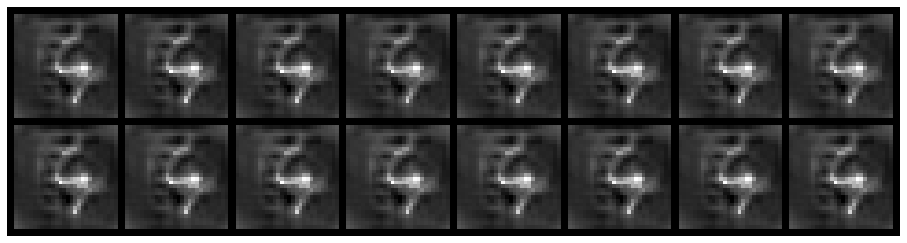

Epoch: [13/50], Batch Num: [0/600]
Discriminator Loss: 0.0584, Generator Loss: 5.3795
D(x): 0.9899, D(G(z)): 0.0350


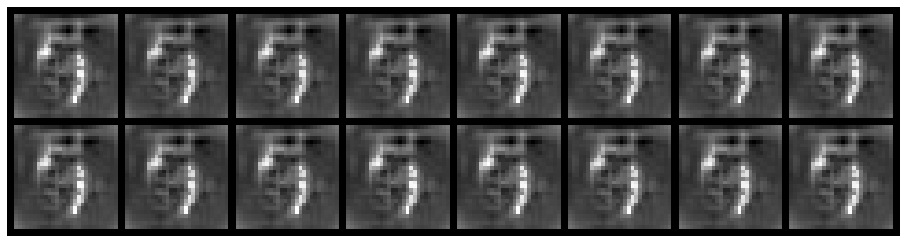

Epoch: [13/50], Batch Num: [100/600]
Discriminator Loss: 0.1306, Generator Loss: 4.6533
D(x): 0.9548, D(G(z)): 0.0254


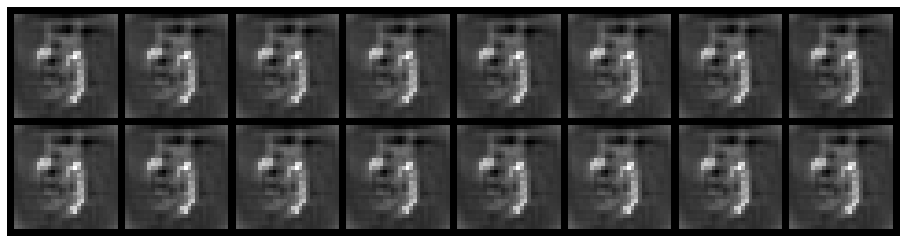

Epoch: [13/50], Batch Num: [200/600]
Discriminator Loss: 0.0855, Generator Loss: 5.1984
D(x): 0.9789, D(G(z)): 0.0199


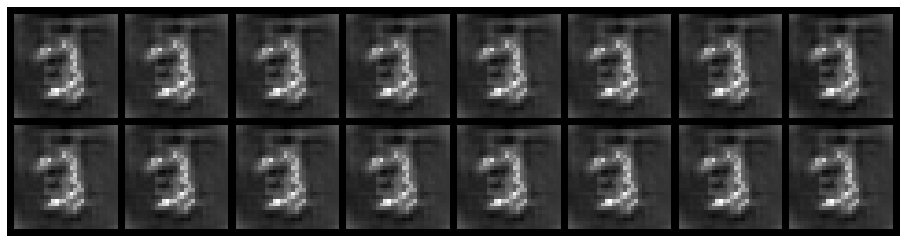

Epoch: [13/50], Batch Num: [300/600]
Discriminator Loss: 0.0162, Generator Loss: 5.8899
D(x): 0.9907, D(G(z)): 0.0059


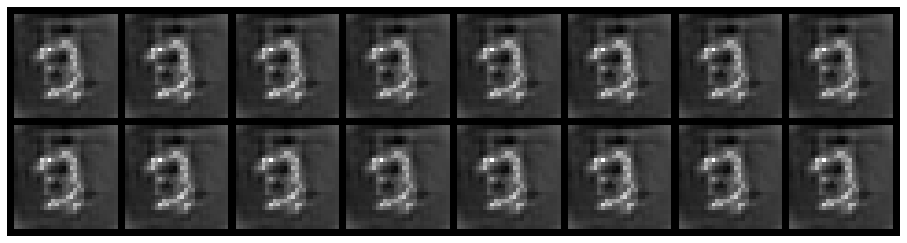

Epoch: [13/50], Batch Num: [400/600]
Discriminator Loss: 0.0512, Generator Loss: 5.5089
D(x): 0.9885, D(G(z)): 0.0193


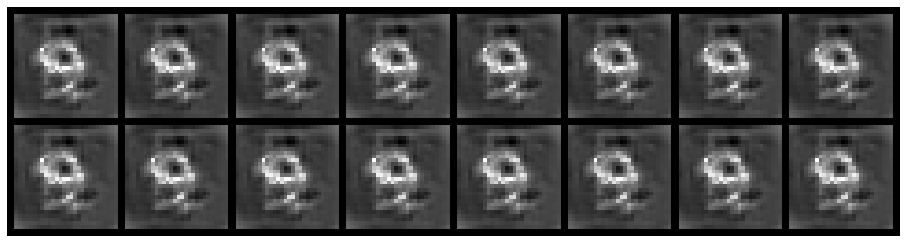

Epoch: [13/50], Batch Num: [500/600]
Discriminator Loss: 0.1476, Generator Loss: 6.7859
D(x): 0.9729, D(G(z)): 0.0053


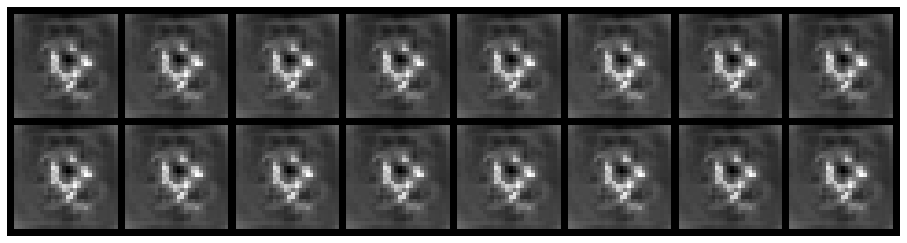

Epoch: [14/50], Batch Num: [0/600]
Discriminator Loss: 0.0616, Generator Loss: 6.0660
D(x): 0.9992, D(G(z)): 0.0406


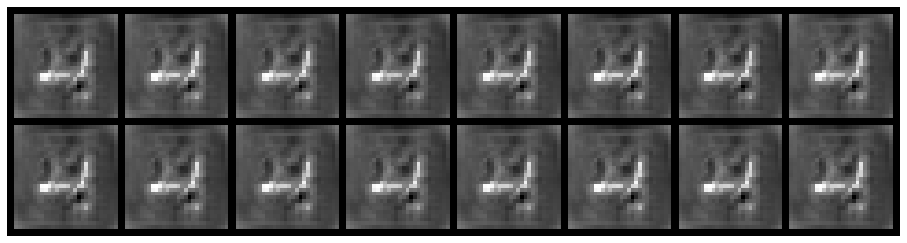

Epoch: [14/50], Batch Num: [100/600]
Discriminator Loss: 0.0234, Generator Loss: 5.4873
D(x): 0.9934, D(G(z)): 0.0150


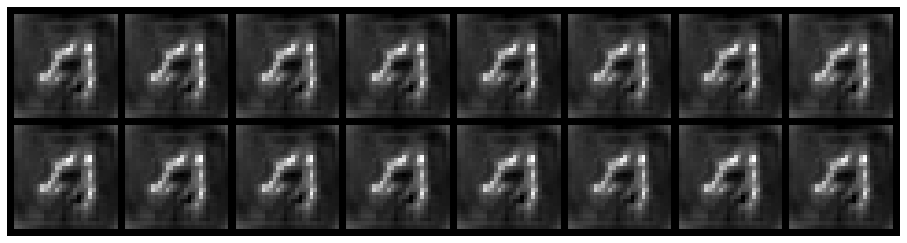

Epoch: [14/50], Batch Num: [200/600]
Discriminator Loss: 0.0345, Generator Loss: 5.6734
D(x): 0.9960, D(G(z)): 0.0260


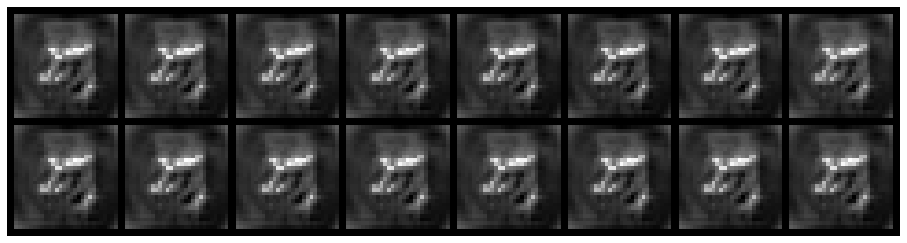

Epoch: [14/50], Batch Num: [300/600]
Discriminator Loss: 0.0406, Generator Loss: 4.9945
D(x): 0.9894, D(G(z)): 0.0190


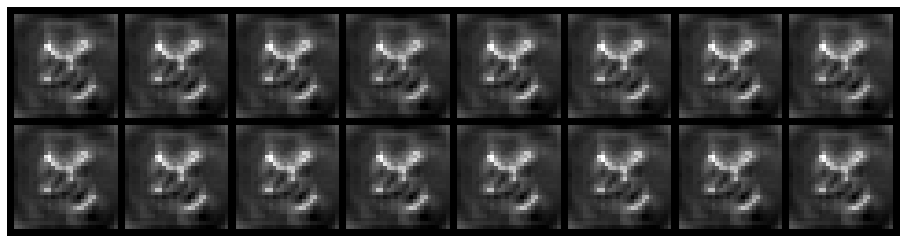

Epoch: [14/50], Batch Num: [400/600]
Discriminator Loss: 0.0883, Generator Loss: 5.4703
D(x): 0.9672, D(G(z)): 0.0080


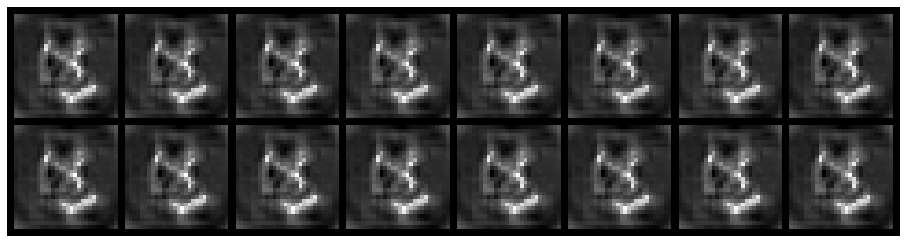

Epoch: [14/50], Batch Num: [500/600]
Discriminator Loss: 0.0437, Generator Loss: 4.7074
D(x): 0.9911, D(G(z)): 0.0254


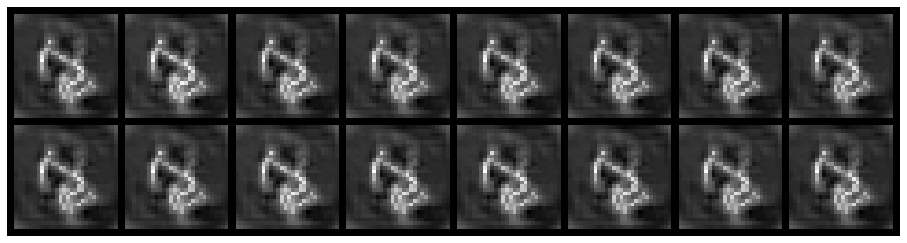

Epoch: [15/50], Batch Num: [0/600]
Discriminator Loss: 0.0122, Generator Loss: 5.8188
D(x): 0.9956, D(G(z)): 0.0073


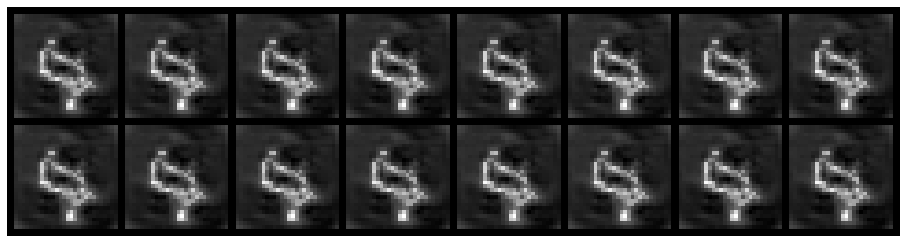

Epoch: [15/50], Batch Num: [100/600]
Discriminator Loss: 0.0261, Generator Loss: 5.4644
D(x): 0.9960, D(G(z)): 0.0202


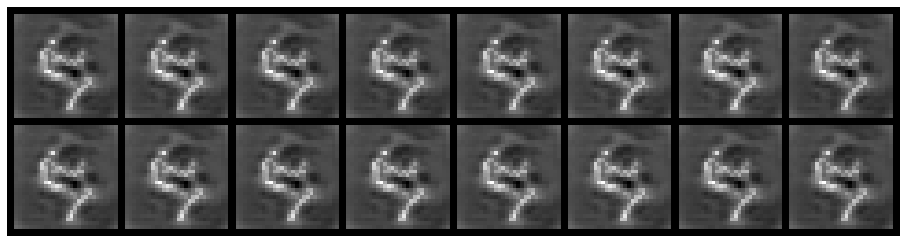

Epoch: [15/50], Batch Num: [200/600]
Discriminator Loss: 0.1059, Generator Loss: 5.7636
D(x): 0.9829, D(G(z)): 0.0100


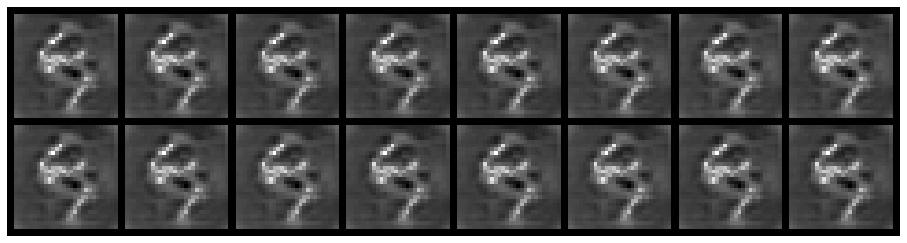

Epoch: [15/50], Batch Num: [300/600]
Discriminator Loss: 0.0282, Generator Loss: 6.2059
D(x): 0.9910, D(G(z)): 0.0075


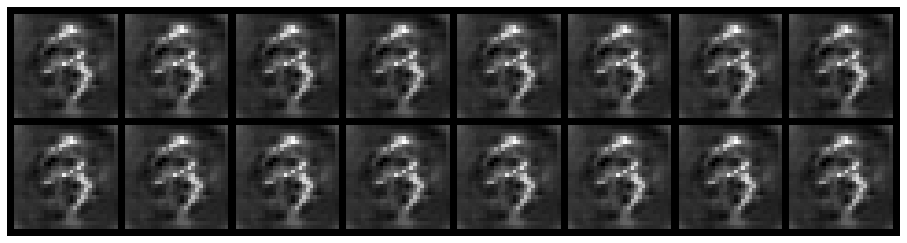

Epoch: [15/50], Batch Num: [400/600]
Discriminator Loss: 0.1145, Generator Loss: 4.6060
D(x): 0.9816, D(G(z)): 0.0232


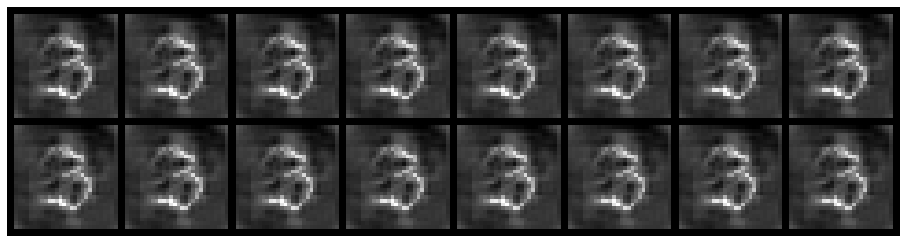

Epoch: [15/50], Batch Num: [500/600]
Discriminator Loss: 0.2133, Generator Loss: 6.9384
D(x): 0.9492, D(G(z)): 0.0659


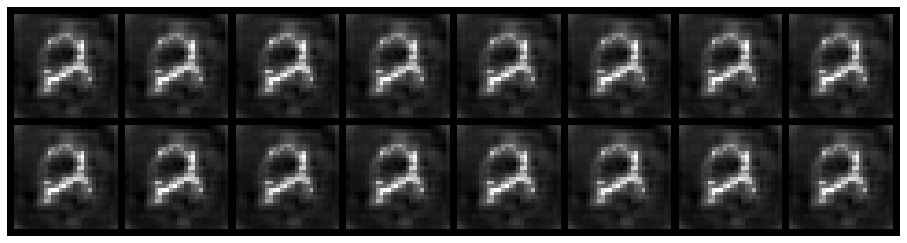

Epoch: [16/50], Batch Num: [0/600]
Discriminator Loss: 0.1377, Generator Loss: 5.9905
D(x): 0.9691, D(G(z)): 0.0129


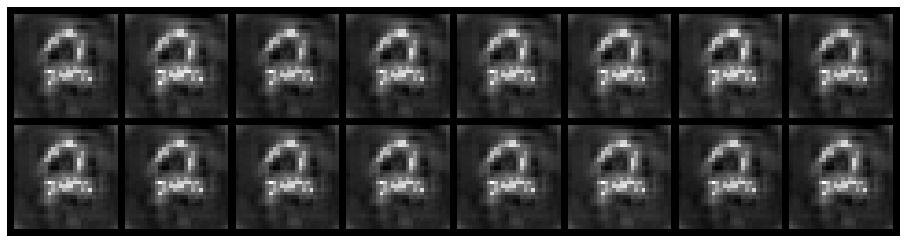

Epoch: [16/50], Batch Num: [100/600]
Discriminator Loss: 0.0400, Generator Loss: 5.3309
D(x): 0.9887, D(G(z)): 0.0131


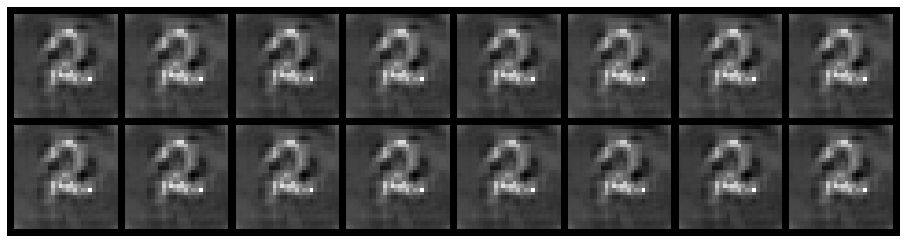

Epoch: [16/50], Batch Num: [200/600]
Discriminator Loss: 0.0326, Generator Loss: 6.2543
D(x): 0.9834, D(G(z)): 0.0061


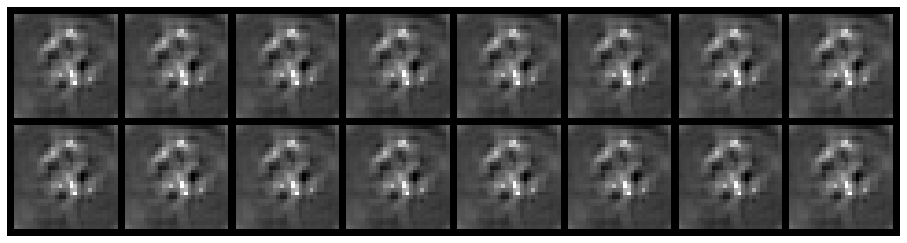

Epoch: [16/50], Batch Num: [300/600]
Discriminator Loss: 0.0783, Generator Loss: 7.1715
D(x): 0.9841, D(G(z)): 0.0060


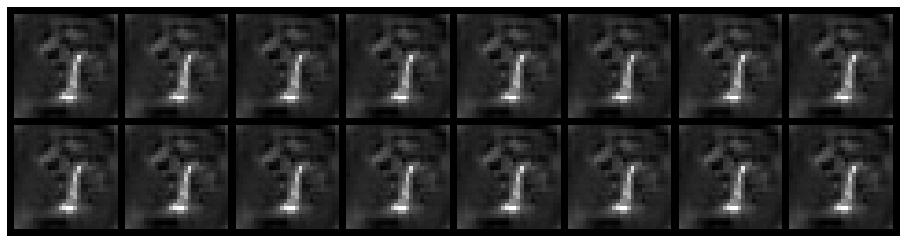

Epoch: [16/50], Batch Num: [400/600]
Discriminator Loss: 0.0362, Generator Loss: 5.7076
D(x): 0.9951, D(G(z)): 0.0260


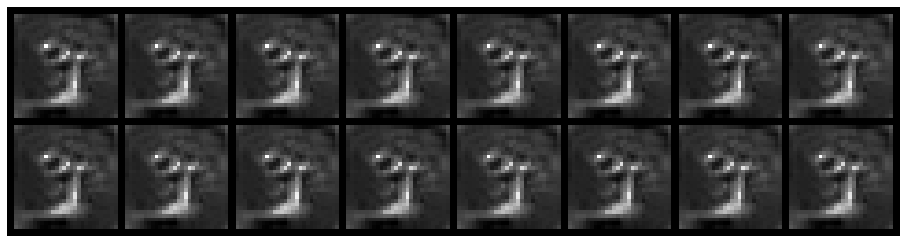

Epoch: [16/50], Batch Num: [500/600]
Discriminator Loss: 0.0621, Generator Loss: 5.1671
D(x): 0.9727, D(G(z)): 0.0186


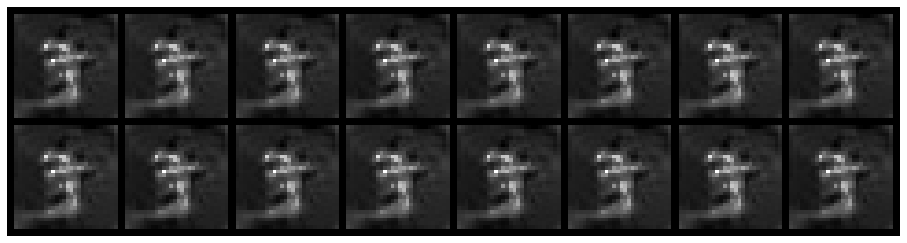

Epoch: [17/50], Batch Num: [0/600]
Discriminator Loss: 0.0351, Generator Loss: 6.2934
D(x): 0.9864, D(G(z)): 0.0109


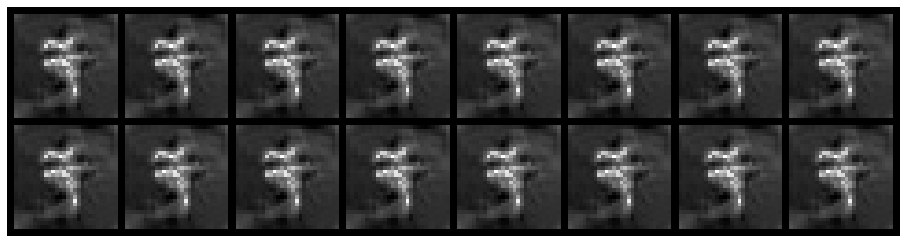

Epoch: [17/50], Batch Num: [100/600]
Discriminator Loss: 0.0135, Generator Loss: 5.5838
D(x): 0.9968, D(G(z)): 0.0096


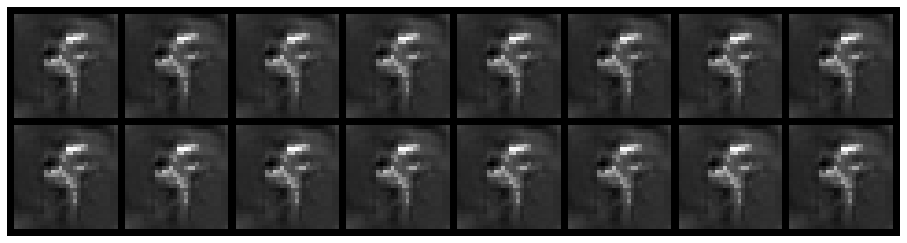

Epoch: [17/50], Batch Num: [200/600]
Discriminator Loss: 0.0375, Generator Loss: 5.5695
D(x): 0.9976, D(G(z)): 0.0275


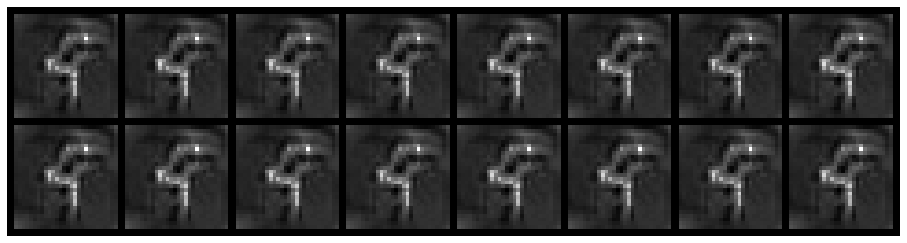

Epoch: [17/50], Batch Num: [300/600]
Discriminator Loss: 0.0453, Generator Loss: 4.7292
D(x): 0.9917, D(G(z)): 0.0266


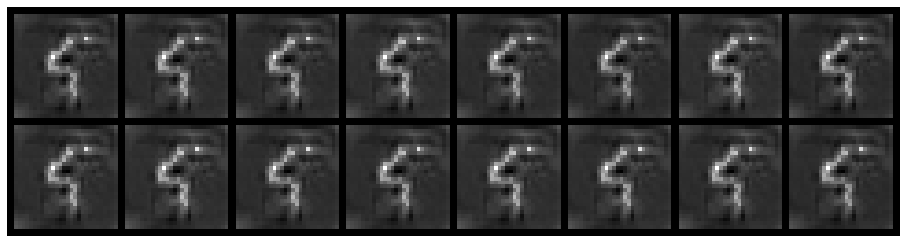

Epoch: [17/50], Batch Num: [400/600]
Discriminator Loss: 0.0771, Generator Loss: 6.4820
D(x): 0.9945, D(G(z)): 0.0502


KeyboardInterrupt: 

In [242]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 50#200

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(image_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        #real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach (so gradients are not calculated for generator)
        fake_data = generator(noise(N).to(device)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_batch.to(device), fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N).to(device))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data.to("cpu")
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

In [125]:
test_images = vectors_to_images(generator(test_noise))

image = test_images.cpu().detach().numpy()
#plt.imshow(image[0][0], cmap='gray', interpolation='none')

## Resources

* https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

## Notes

* When using convtranspose in generator, but not conv in discriminator, after 50 epochs, genearated images are not close to the results obtained when using only linear layers.

## ToDo

* Generator seems to be always generating the same image even if you pass n noise samples, check why.